## Условие задачи

Чтобы оптимизировать производственные расходы, металлургический комбинат решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

### Описание этапа обработки
Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

 ### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

# 1. Исследовательский анализ данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.pyplot import figure
from sklearn.tree import DecisionTreeRegressor
from sklearn import datasets, linear_model, preprocessing


from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix


from time import time


from sklearn.svm import LinearSVC

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import (RandomForestRegressor,
                              AdaBoostRegressor,
                              GradientBoostingRegressor,
                              HistGradientBoostingRegressor)
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [2]:
# Создадим датафреймы из каждого файла
arc = pd.read_csv('/datasets/final_steel/data_arc.csv', parse_dates=['Начало нагрева дугой', 'Конец нагрева дугой'])
wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
temp = pd.read_csv('/datasets/final_steel/data_temp.csv', parse_dates=['Время замера'])
gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv', parse_dates=True)
bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv', parse_dates=True)

In [3]:
arc

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
...,...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768


In [4]:
# Таблица со временем добавления сыпучих материалов не несет для нас никакой полезной информации, т.к. время добавления 
# имеет крайне низкое влияние на тем-ру по сравнению с объмом добавления этих материалов.
bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


### Обработка "Результаты измерения температуры"

In [5]:
temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


In [6]:
temp.describe()

,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


In [7]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           15907 non-null  int64         
 1   Время замера  15907 non-null  datetime64[ns]
 2   Температура   13006 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 372.9 KB


In [8]:
# Сгруппируем таблицу по № партии с указанием начальной тем-ры и конечной и сразу начнем создавать датафрейм с 
# нашими потенциальными признаками. Чтобы NaN учитывались, определим 2 функции:
def first(x):
    return x.values[0]#возвращает первое значение 

def last(x):
    return x.values[-1]#возвращает последнее значение 
df = temp.groupby('key').agg({'Время замера':[first, last], 'Температура':[first, last]})
df.head()

Время замера                     Температура        
                  first                last       first    last
key                                                            
1   2019-05-03 11:16:18 2019-05-03 11:30:39      1571.0  1613.0
2   2019-05-03 11:37:27 2019-05-03 11:59:12      1581.0  1602.0
3   2019-05-03 12:13:17 2019-05-03 12:34:57      1596.0  1599.0
4   2019-05-03 12:52:57 2019-05-03 12:59:25      1601.0  1625.0
5   2019-05-03 13:23:19 2019-05-03 13:36:01      1576.0  1602.0

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 1 to 3241
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   (Время замера, first)  3216 non-null   datetime64[ns]
 1   (Время замера, last)   3216 non-null   datetime64[ns]
 2   (Температура, first)   3216 non-null   float64       
 3   (Температура, last)    2477 non-null   float64       
dtypes: datetime64[ns](2), float64(2)
memory usage: 125.6 KB


In [10]:
# Переименуем столбцы на удобные нам названия
df.columns = ['time_init', 'time_last','temp_init', 'temp_last']
df.head()

,time_init,time_last,temp_init,temp_last
key,,,,
1,2019-05-03 11:16:18,2019-05-03 11:30:39,1571.0,1613.0
2,2019-05-03 11:37:27,2019-05-03 11:59:12,1581.0,1602.0
3,2019-05-03 12:13:17,2019-05-03 12:34:57,1596.0,1599.0
4,2019-05-03 12:52:57,2019-05-03 12:59:25,1601.0,1625.0
5,2019-05-03 13:23:19,2019-05-03 13:36:01,1576.0,1602.0


In [11]:
# Удалим партии, где последняя температура не заполнена:
df = df[df['temp_last'] == df['temp_last']]

In [12]:
# Добавим столбец с разницей(в сек) между последним временем измерения и начальным
df['diff_time'] = (df['time_last'] - df['time_init']).dt.total_seconds()

In [13]:
# Удалим строки, где измерение проводилось только 1 раз(время нач = время конеч)
df = df[df['diff_time'] != 0]

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 1 to 2499
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   time_init  2475 non-null   datetime64[ns]
 1   time_last  2475 non-null   datetime64[ns]
 2   temp_init  2475 non-null   float64       
 3   temp_last  2475 non-null   float64       
 4   diff_time  2475 non-null   float64       
dtypes: datetime64[ns](2), float64(3)
memory usage: 116.0 KB


In [15]:
df.describe()

,temp_init,temp_last,diff_time
count,2475.000000,2475.000000,2475.000000
mean,1588.402020,1595.336162,1854.953939
std,29.243044,16.023153,1301.241764
min,1191.000000,1541.000000,234.000000
25%,1572.000000,1587.000000,1182.500000
50%,1588.000000,1593.000000,1593.000000
75%,1605.000000,1599.000000,2262.500000
max,1679.000000,1700.000000,23537.000000


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 1 to 2499
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   time_init  2475 non-null   datetime64[ns]
 1   time_last  2475 non-null   datetime64[ns]
 2   temp_init  2475 non-null   float64       
 3   temp_last  2475 non-null   float64       
 4   diff_time  2475 non-null   float64       
dtypes: datetime64[ns](2), float64(3)
memory usage: 116.0 KB


/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='temp_init', ylabel='Density'>

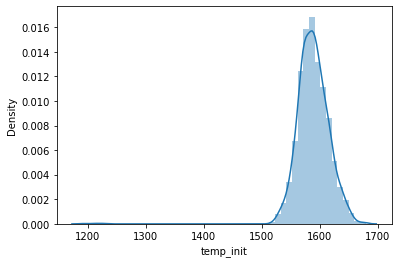

In [17]:
# Посмотрим распределение начальной тем-ры
sns.distplot(a=df['temp_init'])

<AxesSubplot:xlabel='temp_init'>

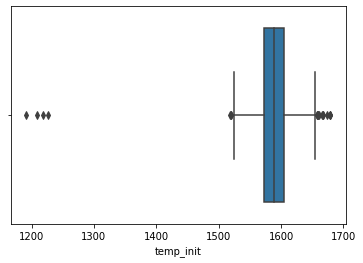

In [18]:
# Посмотрим боксплот
sns.boxplot(x=df['temp_init'])

In [19]:
# Посмотрим на строки с аномалиями
df[df['temp_init']<=1500]

,time_init,time_last,temp_init,temp_last,diff_time
key,,,,,
867,2019-06-04 14:21:00,2019-06-04 14:57:17,1191.0,1599.0,2177.0
1214,2019-06-16 05:32:00,2019-06-16 06:14:45,1208.0,1591.0,2565.0
1619,2019-06-30 11:03:54,2019-06-30 11:21:54,1218.0,1590.0,1080.0
2052,2019-07-21 14:51:40,2019-07-21 15:24:06,1227.0,1592.0,1946.0


In [20]:
# Удалим аномалии для улучшения качества данных
df = df[df['temp_init']>1500]

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='temp_init', ylabel='Density'>

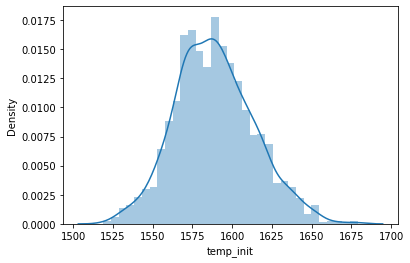

In [21]:
sns.distplot(a=df['temp_init'])

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='temp_last', ylabel='Density'>

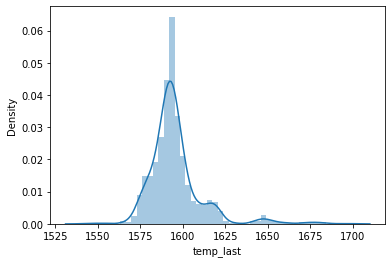

In [22]:
# Посмотрим распределение конечной тем-ры
sns.distplot(a=df['temp_last'])

<AxesSubplot:xlabel='temp_last'>

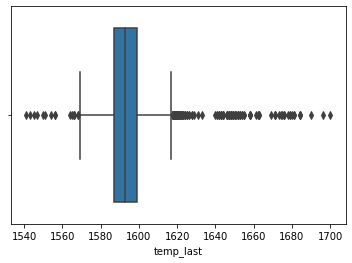

In [23]:
# Посмотрим боксплот
sns.boxplot(x=df['temp_last'])

Видим маленький тонкий хвост после 1640, тянущийся за 1700. Он 

In [24]:
len(df[df['temp_last']>=1640])/len(df)

0.032780250910562525

In [25]:
# Посмотрим на строки с аномалиями
df[df['temp_last']>=1640]

,time_init,time_last,temp_init,temp_last,diff_time
key,,,,,
51,2019-05-05 05:48:48,2019-05-05 06:10:21,1619.0,1690.0,1293.0
52,2019-05-05 06:21:58,2019-05-05 06:54:08,1617.0,1669.0,1930.0
53,2019-05-05 07:04:58,2019-05-05 07:38:14,1642.0,1671.0,1996.0
54,2019-05-05 07:49:38,2019-05-05 08:18:57,1630.0,1663.0,1759.0
55,2019-05-05 08:27:17,2019-05-05 08:57:46,1615.0,1654.0,1829.0
...,...,...,...,...,...
2389,2019-08-02 07:29:15,2019-08-02 07:44:39,1653.0,1646.0,924.0
2390,2019-08-02 08:16:44,2019-08-02 08:22:39,1679.0,1648.0,355.0
2391,2019-08-02 08:44:19,2019-08-02 09:06:45,1623.0,1644.0,1346.0


In [26]:
# Удалим аномалии для улучшения качества данных
df = df[df['temp_last']<1640]

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='temp_last', ylabel='Density'>

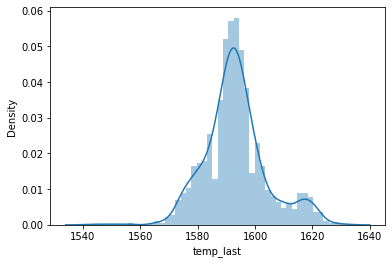

In [27]:
sns.distplot(a=df['temp_last'])

### Обработка "Данные об электродах"

In [28]:
arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


In [29]:
arc_agg = arc.groupby('key').agg({'Активная мощность':'sum', 
                         'Реактивная мощность':'sum'})
arc_agg.columns = ['active_power','reactive_power']
arc_agg

,active_power,reactive_power
key,,
1,4.878147,3.183241
2,3.052598,1.998112
3,2.525882,1.599076
4,3.209250,2.060298
5,3.347173,2.252643
...,...,...
3237,3.932467,2.828459
3238,2.106529,1.681182
3239,4.666754,3.111617


<font color='blue'> 
### <u>КОММЕНТАРИЙ РЕВЬЮЕРА</u>
</font>
<font color='green'>
ок, здорово, сразу собрали.

In [30]:
df = df.join(arc_agg)
#df.head(3)

### Обработка "Данные о подаче сыпучих материалов (объём)"

In [31]:
bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [32]:
#Заменим Nan на 0
bulk.fillna(0, inplace=True)

In [33]:
# Добавим столбец с суммой материалов по каждой партии и создадим новую таблицу с этим столбцом для добавления его в общую таблицу с признаками
bulk['sum_bulk'] = bulk.iloc[:,1:].sum(axis=1)
bulk_agg = bulk[['key', 'sum_bulk']].set_index(['key'])



In [34]:
bulk_agg

,sum_bulk
key,
1,553.0
2,582.0
3,544.0
4,595.0
5,584.0
...,...
3237,758.0
3238,594.0
3239,630.0


<font color='blue'> 
### <u>КОММЕНТАРИЙ РЕВЬЮЕРА</u>
</font>
<font color='green'>
ок, хорошо)

In [35]:
df = df.join(bulk_agg)

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2390 entries, 1 to 2499
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   time_init       2390 non-null   datetime64[ns]
 1   time_last       2390 non-null   datetime64[ns]
 2   temp_init       2390 non-null   float64       
 3   temp_last       2390 non-null   float64       
 4   diff_time       2390 non-null   float64       
 5   active_power    2390 non-null   float64       
 6   reactive_power  2390 non-null   float64       
 7   sum_bulk        2341 non-null   float64       
dtypes: datetime64[ns](2), float64(6)
memory usage: 232.6 KB


In [37]:
df.fillna(0, inplace=True)

### Обработка "Данные о продувке сплава газом"

In [38]:
gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [39]:
gas = gas.set_index(['key'])

In [40]:
df=df.join(gas)

### Обработка "Данные о проволочных материалах (объём)"

In [41]:
wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [42]:
wire.fillna(0, inplace=True)
wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
wire['sum_wire'] = wire.iloc[:,1:].sum(axis=1)
wire_agg = wire[['key', 'sum_wire']].set_index(['key'])
wire_agg.head()

,sum_wire
key,
1,60.059998
2,96.052315
3,91.160157
4,89.063515
5,98.352796


In [44]:
df=df.join(wire_agg)

In [45]:
df.head()

,time_init,time_last,temp_init,temp_last,diff_time,active_power,reactive_power,sum_bulk,Газ 1,sum_wire
key,,,,,,,,,,
1,2019-05-03 11:16:18,2019-05-03 11:30:39,1571.0,1613.0,861.0,4.878147,3.183241,553.0,29.749986,60.059998
2,2019-05-03 11:37:27,2019-05-03 11:59:12,1581.0,1602.0,1305.0,3.052598,1.998112,582.0,12.555561,96.052315
3,2019-05-03 12:13:17,2019-05-03 12:34:57,1596.0,1599.0,1300.0,2.525882,1.599076,544.0,28.554793,91.160157
4,2019-05-03 12:52:57,2019-05-03 12:59:25,1601.0,1625.0,388.0,3.209250,2.060298,595.0,18.841219,89.063515
5,2019-05-03 13:23:19,2019-05-03 13:36:01,1576.0,1602.0,762.0,3.347173,2.252643,584.0,5.413692,98.352796


In [46]:
df.fillna(0, inplace=True)

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2390 entries, 1 to 2499
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   time_init       2390 non-null   datetime64[ns]
 1   time_last       2390 non-null   datetime64[ns]
 2   temp_init       2390 non-null   float64       
 3   temp_last       2390 non-null   float64       
 4   diff_time       2390 non-null   float64       
 5   active_power    2390 non-null   float64       
 6   reactive_power  2390 non-null   float64       
 7   sum_bulk        2390 non-null   float64       
 8   Газ 1           2390 non-null   float64       
 9   sum_wire        2390 non-null   float64       
dtypes: datetime64[ns](2), float64(8)
memory usage: 269.9 KB


In [48]:
# Удалим признаки со временем, т.к. есть признак с длительностью в сек. Этого будет достаточно. 
df = df.drop(['time_init', 'time_last'], axis=1)

### Статистический анализ

In [49]:
df.describe()

,temp_init,temp_last,diff_time,active_power,reactive_power,sum_bulk,Газ 1,sum_wire
count,2390.000000,2390.000000,2390.000000,2390.000000,2390.000000,2390.000000,2390.000000,2390.000000
mean,1587.451464,1593.234310,1879.252720,3.116215,2.026493,596.739749,11.256654,123.878206
std,23.645118,11.093853,1313.649768,1.431700,14.704725,297.070988,6.371831,64.955799
min,1519.000000,1541.000000,234.000000,0.186226,-714.591636,0.000000,0.000000,0.000000
25%,1571.000000,1587.000000,1200.250000,2.127487,1.599856,420.000000,7.228128,86.979358
50%,1587.000000,1593.000000,1620.000000,2.990862,2.220178,602.500000,10.000410,115.268402
75%,1603.000000,1598.000000,2275.750000,3.901147,2.896354,789.750000,14.066082,151.295819
max,1673.000000,1633.000000,23537.000000,17.496497,12.587990,3235.000000,77.995040,568.777664


/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='reactive_power', ylabel='Density'>

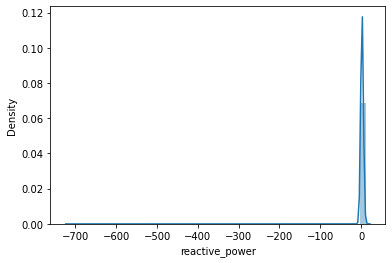

In [50]:
# Посмотрим на распределение реактивной мощности
sns.distplot(df['reactive_power'])

In [51]:
# Посмотрим на аномалии
df[df['reactive_power']<=0]

,temp_init,temp_last,diff_time,active_power,reactive_power,sum_bulk,Газ 1,sum_wire
key,,,,,,,,
2116,1579.0,1578.0,1232.0,1.848681,-714.591636,335.0,11.582547,75.216965


In [52]:
# Удалим аномалии
df = df[df['reactive_power']>0]

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='reactive_power', ylabel='Density'>

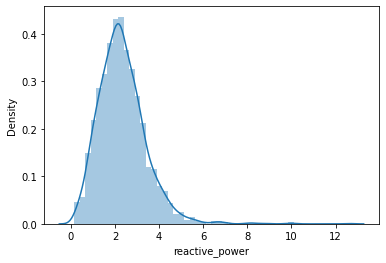

In [53]:
sns.distplot(df['reactive_power'])

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='active_power', ylabel='Density'>

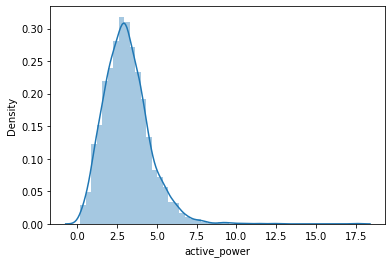

In [54]:
sns.distplot(df['active_power'])

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sum_bulk', ylabel='Density'>

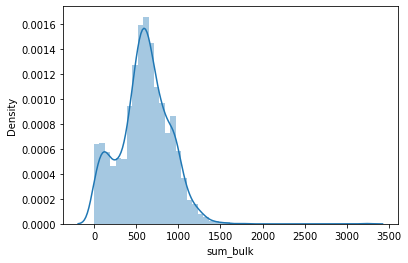

In [55]:
sns.distplot(df['sum_bulk'])

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Газ 1', ylabel='Density'>

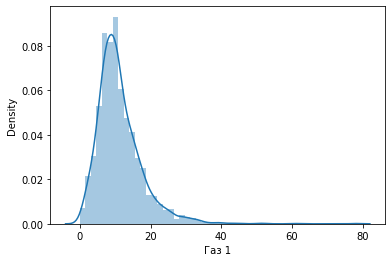

In [56]:
sns.distplot(df['Газ 1'])

In [57]:
len(df[df['Газ 1'] > 40])

7

In [58]:
df = df[df['Газ 1'] < 40]

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sum_wire', ylabel='Density'>

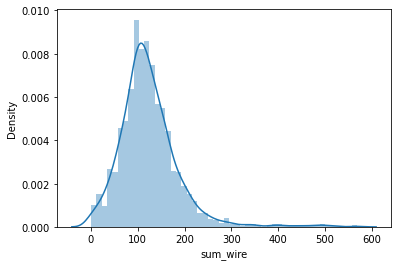

In [59]:
sns.distplot(df['sum_wire'])

In [60]:
len(df[df['sum_wire'] > 300]) / len(df)

0.017632241813602016

In [61]:
df = df[df['sum_wire'] < 300]

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sum_wire', ylabel='Density'>

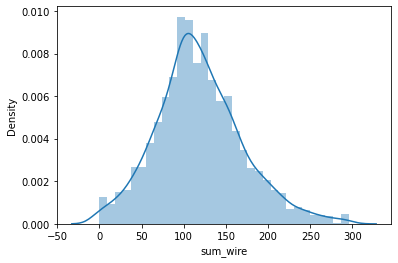

In [62]:
sns.distplot(df['sum_wire'])

In [63]:
# Для удобства переименуем столбец Газ 1
df.rename(columns={'Газ 1':'sum_gas'}, inplace=True)

<AxesSubplot:xlabel='active_power', ylabel='reactive_power'>

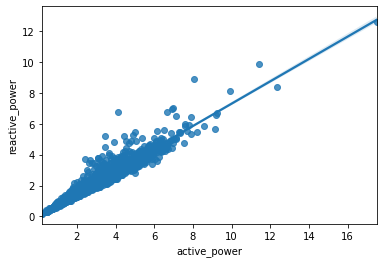

In [64]:
# Посмотрим на корреляцию активной и реактивной мощности. Видим прямую сильную взаимосвяязь.
# Надо будет какой-то из этих признаков удалить из нашей модели
sns.regplot(x=df['active_power'], y=df['reactive_power'])

In [65]:
# Посмотрим матрицу корреляций
df.corr()

,temp_init,temp_last,diff_time,active_power,reactive_power,sum_bulk,sum_gas,sum_wire
temp_init,1.000000,0.321932,0.188022,-0.448352,-0.428635,-0.133647,0.014990,0.167819
temp_last,0.321932,1.000000,0.133957,0.291237,0.247358,0.215002,0.067636,0.101137
diff_time,0.188022,0.133957,1.000000,0.541454,0.530753,0.331718,0.441605,0.228294
active_power,-0.448352,0.291237,0.541454,1.000000,0.959334,0.587767,0.366987,0.088311
reactive_power,-0.428635,0.247358,0.530753,0.959334,1.000000,0.544229,0.343592,0.061777
sum_bulk,-0.133647,0.215002,0.331718,0.587767,0.544229,1.000000,0.308751,0.081230
sum_gas,0.014990,0.067636,0.441605,0.366987,0.343592,0.308751,1.000000,0.202890
sum_wire,0.167819,0.101137,0.228294,0.088311,0.061777,0.081230,0.202890,1.000000


<AxesSubplot:>

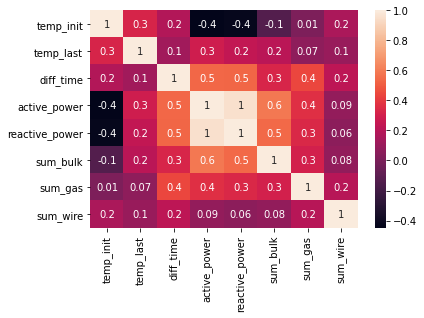

In [66]:
# Посмотрим тепловую карту, которая показывает влияние какждого признака на целевую переменную.
sns.heatmap(df.corr(), annot = True, fmt='.1g')

In [67]:
# Удалим реактивную мощность, т.к. у нее меньшее значение корреляции по сравнению с активной
df = df.drop('reactive_power', axis=1)

In [68]:
df.corr()

,temp_init,temp_last,diff_time,active_power,sum_bulk,sum_gas,sum_wire
temp_init,1.000000,0.321932,0.188022,-0.448352,-0.133647,0.014990,0.167819
temp_last,0.321932,1.000000,0.133957,0.291237,0.215002,0.067636,0.101137
diff_time,0.188022,0.133957,1.000000,0.541454,0.331718,0.441605,0.228294
active_power,-0.448352,0.291237,0.541454,1.000000,0.587767,0.366987,0.088311
sum_bulk,-0.133647,0.215002,0.331718,0.587767,1.000000,0.308751,0.081230
sum_gas,0.014990,0.067636,0.441605,0.366987,0.308751,1.000000,0.202890
sum_wire,0.167819,0.101137,0.228294,0.088311,0.081230,0.202890,1.000000


In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2340 entries, 1 to 2499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   temp_init     2340 non-null   float64
 1   temp_last     2340 non-null   float64
 2   diff_time     2340 non-null   float64
 3   active_power  2340 non-null   float64
 4   sum_bulk      2340 non-null   float64
 5   sum_gas       2340 non-null   float64
 6   sum_wire      2340 non-null   float64
dtypes: float64(7)
memory usage: 146.2 KB


In [70]:
df.describe()

,temp_init,temp_last,diff_time,active_power,sum_bulk,sum_gas,sum_wire
count,2340.000000,2340.000000,2340.000000,2340.000000,2340.000000,2340.000000,2340.000000
mean,1587.382906,1593.293162,1855.300000,3.102023,598.049145,11.061845,118.484803
std,23.466248,11.022285,1247.778354,1.416481,290.626718,5.921863,51.590454
min,1519.000000,1543.000000,234.000000,0.186226,0.000000,0.000000,0.000000
25%,1571.000000,1587.000000,1192.750000,2.124492,429.000000,7.138971,86.053495
50%,1587.000000,1593.000000,1601.000000,2.985844,604.500000,9.944503,114.361518
75%,1603.000000,1598.000000,2264.000000,3.889118,790.000000,13.873241,149.193718
max,1673.000000,1633.000000,23537.000000,17.496497,1757.000000,39.728826,295.364159


### Подготовка выборок




Необходимо разбить данные на 3 выборки: обучающую, валидационную и тестовую. Размеры тестового и валидационного наборов обычно равны. Исходные данные разбивают в соотношении 3:1:1. Используем метод train_test_split дважды. Сначала разобьем весь датасет на 60%(обучающая выборка) и остальное. Затем остальное на валидационную и тестовую по 50%.

In [71]:
y = df['temp_last']
X = df.drop('temp_last', axis=1)
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1234)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.25, random_state=1234)

print(f"Train shape: {X_train.shape}")
print(f"Validation shape: {X_val.shape}")
print(f"Test shape: {X_test.shape}")

Train shape: (1404, 6)
Validation shape: (468, 6)
Test shape: (468, 6)


In [72]:
X.columns

Index(['temp_init', 'diff_time', 'active_power', 'sum_bulk', 'sum_gas',
       'sum_wire'],
      dtype='object')

### Выводы:
1) Итого у нас получился датасет с кол-вом строк 2316. 6 признаков, один из которых целевой.

2) Все признаки количественные, поэтому кодирование не требуется

3) Большинство признаков имеют близкое к нормальному распределение, что говорит о хорошем качестве данных

4) Из 3216 партий только по 2475 измеряли 2 раза температуру. Таким образом, остальные партии нам пришлось удалить, т.к. не было значений целевого признака.

# 2. Обучение моделей.

In [73]:
# Настройка таблицы с результатами
df_results = pd.DataFrame(columns=['mae', 'run_time'])

In [74]:
# Подберем лучший гиперпараметр для дерева решений:
for depth in range(1, 13):
    m = DecisionTreeRegressor(random_state=1234, max_depth=depth)
    start_time = time()
    m.fit(X_train, y_train)
    run_time = time() - start_time
    y_pred = m.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)
    print("max_depth =", depth, "; ", end='')
    print("mae =", mae, "; ", end='')
    print("run_time =", run_time)
    print("-------------------------------")

max_depth = 1 ; mae = 7.939212714134832 ; run_time = 0.0028188228607177734
-------------------------------
max_depth = 2 ; mae = 7.350045395317666 ; run_time = 0.003795623779296875
-------------------------------
max_depth = 3 ; mae = 7.149484280544959 ; run_time = 0.003528118133544922
-------------------------------
max_depth = 4 ; mae = 6.965104903547901 ; run_time = 0.003655672073364258
-------------------------------
max_depth = 5 ; mae = 6.725883085536078 ; run_time = 0.0048351287841796875
-------------------------------
max_depth = 6 ; mae = 6.8659713390948784 ; run_time = 0.004996776580810547
-------------------------------
max_depth = 7 ; mae = 7.095579222677747 ; run_time = 0.005612611770629883
-------------------------------
max_depth = 8 ; mae = 6.936443569277846 ; run_time = 0.018944501876831055
-------------------------------
max_depth = 9 ; mae = 6.988569062404548 ; run_time = 0.005901336669921875
-------------------------------
max_depth = 10 ; mae = 7.016591793140139 ; 

Лучшая модель с глубиной 5.

In [75]:
# Укажем все наши возможные модели:
dt = DecisionTreeRegressor(max_depth=5, random_state=1234)
base_estim = DecisionTreeRegressor(max_depth=5, max_features=0.06)                            
ab = AdaBoostRegressor(base_estimator=base_estim,
                        random_state=1234)
rf = RandomForestRegressor(random_state = 1234)
xgb = XGBRegressor(random_state = 1234)
lgbm = LGBMRegressor(random_state=1234)
cb = CatBoostRegressor(random_state=1234, verbose=False)
hgbm = HistGradientBoostingRegressor(random_state=1234)
gbm = GradientBoostingRegressor(random_state=1234)
lg = LinearRegression()

In [76]:
models = [dt, rf, ab, xgb, gbm, hgbm, lgbm, cb, lg]
model_names = [i.__class__.__name__ for i in models]

In [77]:
#  Обучим и проверим все наши модели
for m, n in zip(models, model_names):
    
    start_time = time()
    m.fit(X_train, y_train)    
    run_time = time() - start_time
    y_pred = m.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)
        
    df_results.loc[n] = [mae, run_time]
    
    del m

In [78]:
# Константная модель. Любому объекту модель прогнозирует среднее значение:
start_time = time()
y_pred = pd.Series([y_train.mean()]*len(y_val))
run_time = time() - start_time
mae = mean_absolute_error(y_val, y_pred)
df_results.loc['Constant Model'] = [mae, run_time]

In [79]:
df_results

,mae,run_time
DecisionTreeRegressor,6.725883,0.004737
RandomForestRegressor,5.794017,0.505483
AdaBoostRegressor,6.982361,0.102440
XGBRegressor,6.160499,50.827312
GradientBoostingRegressor,5.786511,0.267289
HistGradientBoostingRegressor,5.789432,3.579888
LGBMRegressor,5.827623,0.598037
CatBoostRegressor,5.569389,2.295453
LinearRegression,5.742114,0.001963
Constant Model,8.090127,0.000613


<AxesSubplot:xlabel='mae'>

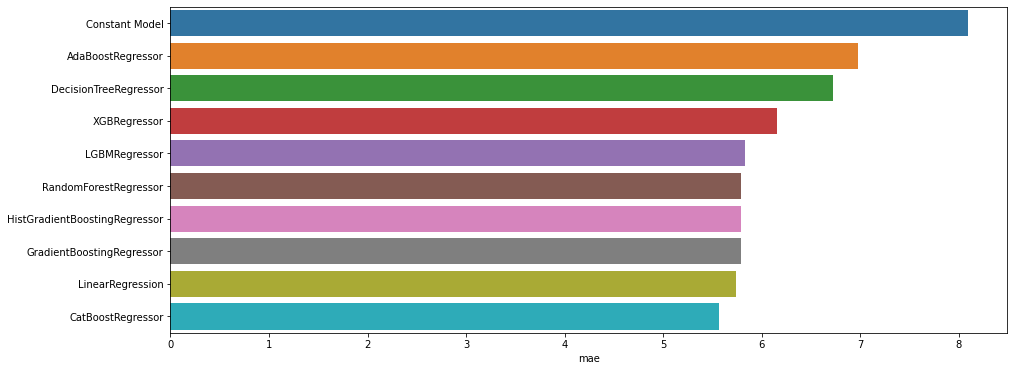

In [80]:
df_results.sort_values('mae', ascending=False, inplace=True)
plt.figure(figsize=(15,6))
sns.barplot(y = df_results.index, x=df_results['mae'])

#### Вывод: обучение проведено корректно, константная модель хуже всех, Catboost - лучше всех.

# 3. Тестирование модели

In [81]:
# Для обучения возьмем объединную выборку(train и valid)
print(f"Trainval shape: {X_trainval.shape}")
print(f"Test shape: {X_test.shape}")

Trainval shape: (1872, 6)
Test shape: (468, 6)


In [82]:
best_model = cb
start_time = time()
best_model.fit(X_trainval, y_trainval)
run_time = time() - start_time
y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print("mae =", mae, "; ", end='')
print("run_time =", run_time)

mae = 5.687817212849062 ; run_time = 2.614049196243286


<AxesSubplot:xlabel='Coefficient'>

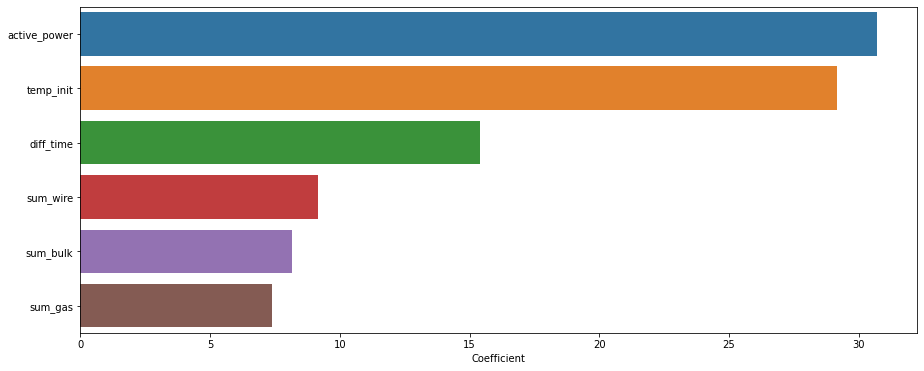

In [83]:
# Построим график с указанием влияния каждого признака. 
# Важность показывает, насколько в среднем изменяется целевой признак при изменении значения признака на 1 ед. 
# Чем больше значение влияния, тем больше в среднем значение целевого признака, если этот признак был изменен.
coeff_df = pd.DataFrame(best_model.feature_importances_, best_model.feature_names_, columns=['Coefficient'])  
coeff_df.sort_values('Coefficient', ascending=False, inplace=True)
plt.figure(figsize=(15,6))
sns.barplot(y = coeff_df.index, x=coeff_df['Coefficient'])

### Вывод: Ура! Мы выполнили поставленную задачу. MAE < 6.0. Значение конечной температуры наиболее чувствительно к изменению активной мощности и начальной температуры. Наименьшее значение на целевой признак оказывает изменение объема инертного газа.

### Огромное спасибо за четкие комментарии! 

### Выводы:

1) Выполнены все пункты плана: проведение EDA  и Feature Engineering, обучение моделей, тестирование лучшей модели. В ходе подготовки данных отказался от масштабирования признаков, т.к. оно ухудшало результат обучения. Скорее всего из-за того, что начальная тем-ра действительно имеет очень большое влияние на целевой признак, а масштабирование снижает ее вес в модели.

2) Сложность возникла с удалением всей партии, если пропущено значение последней температуры. В данном случае агрегирование по last не помогает, т.к. при этом функция берет последнее заполненное значение, а необходимо было, чтобы выводились и NaN. Пришлось погуглить) В итоге определил 2 функции, которые берут соответственно начальное и конечное значение из списка. По ним сделал агрегацию и NaN успешно вывелись). 

Также при первоначальном обучении моделей качество получилось соответствующим минимальным требованиям, но все-таки достаточно низким. При анализе отклонений предсказаний от истинных значений выяснилось, что модель чаще и существеннее ошибалась на объектах, которые имели истинное значение конечной температуры выше 1640. При анализе значений конечной температуры с помощью графика boxplot выяснилось, что после этого рубежа идет достаточно длинный шлейф(в диапазоне от 1640 до 1720 градусов) значений, которые составляли 3% от всего датасета. Таким образом модель получает очень мало данных на этом достаточно широком диапазоне и не может корректно их предсказывать. После удаления этих значений качество предсказаний существенно выросло. 

3) Ключевые шаги в решении задачи:
- провести качественный EDA и Feature Engineering: отобрать или создать именно те признаки для нашей модели, которые помогут получить наилучшее качество. При отборе фичей я руководствовался описанием проекта и знаниями физики, чтобы фичи в первую очередь сходились с реальностью. Затем уже смотрел матрицу корреляций и боролся с мультикоррелиарностью. Также здесь очень было важно посмотреть на распределения значений и удалить выбросы. Также очень важно было не насоздавать излишне большого количества фич, т.к. это может негативно отразиться как на качестве предсказаний, так и на времени обучения моделей.
- при обучении моделей важно было сразу создать список всех возможных моделей и автоматизировать процесс обучения. Возможно, мне повезло, но практически сходу я получил приемлемое качество. Практически не пришлось возиться с признаками(исключать или добавлять новые).
- после тестирования итоговой модели важно было вывести график с указием влияния каждого признака на конечную температуру. Ведь на самом деле именно скорее всего этого от нас и ждет бизнес, чтобы иметь возможность самому регулировать конечную температуру в ходе дальнейшего использования нашей модели. Таким образом, он будет понимать примерно, как мы получаем предсказания и к нашему труду будет существенно больше доверия, нежели если бы мы просто представили как результат значение МАЕ.

4) Итоговая модель - CatBoostRegressor. МАЕ - 5.7.